# EfficientDet with OpenVINO™
Research Paper : [EfficientDet: Scalable and Efficient Object Detection](https://openaccess.thecvf.com/content_CVPR_2020/papers/Tan_EfficientDet_Scalable_and_Efficient_Object_Detection_CVPR_2020_paper.pdf)\
EfficientDets are a family of object detection models, which achieve state-of-the-art 55.1mAP on COCO test-dev, yet being 4x - 9x smaller and using 13x - 42x fewer FLOPs than previous detectors. Our models also run 2x - 4x faster on GPU, and 5x - 11x faster on CPU than other detectors.\
<img src='https://raw.githubusercontent.com/google/automl/master/efficientdet/g3doc/network.png' width=450 height=200>
<img src='https://raw.githubusercontent.com/google/automl/master/efficientdet/g3doc/params.png' width=250 height=200>\
In this notebook, you will learn how to use the EfficientDet model and optimize it with OpenVINO API

## The tutorial consists of the following steps:

* Downloading and exporting the efficientDet-d0 from TensorFlow-HUB
  * Validating inference of tf-model
* Converting tf-model to OpenVINO-IR(Intermediate representation) file
  * Validating inference of OpenVINO-model
  * Evaluating performance by AP( average Precision)

[Will be included later]
* Post-training optimization with OpenVINO NNCF (Neural Network Compression Framework)
  * Quantization of FP16/32 model to INT8 model
  * Validating Inference of INT8 model
  * Evaluating performance of INT8 model by AP


### Prerequisites

In [ ]:
# These dependencies will be added to the requirements.txt once approved.
!pip install tensorflow-hub pycocotools

In [22]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import cv2
import matplotlib.pyplot as plt

import pathlib
import json
import sys

sys.path.append('../utils/')
from notebook_utils import load_image , download_file

### Downloading the model
* Download a pre-trained model of EfficientDet with help of tensorflow_hub API.
* [TensorFlow Hub](https://tfhub.dev/) is a repository of reusable assets for machine learning with TensorFlow. In particular, it provides pre-trained SavedModels that can be reused to solve new tasks with less training time and less training data.
* You can choose any model from the EfficientDet family , right now you will use [efficientdet-d0](https://tfhub.dev/tensorflow/efficientdet/d0/1) for this notebook.

In [ ]:
efficientDet_d0 = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
model = hub.load(efficientDet_d0)

### Utility Functions


In [24]:
# COCO-2017 label
coco_label = {0:'__background__',1: 'person',2: 'bicycle',3: 'car',4: 'motorcycle',5: 'airplane',6: 'bus',7: 'train',8: 'truck',9: 'boat',
              10: 'traffic light',11: 'fire hydrant',12: 'street sign',13: 'stop sign',14: 'parking meter',15: 'bench',16: 'bird',
              17: 'cat',18: 'dog',19: 'horse',20: 'sheep',21: 'cow',22: 'elephant',23: 'bear',24: 'zebra',25: 'giraffe',
              26: 'hat',27: 'backpack',28: 'umbrella',29: 'shoe',30: 'eye glasses',31: 'handbag',32: 'tie',33: 'suitcase',34: 'frisbee',
              35: 'skis',36: 'snowboard',37: 'sports ball',38: 'kite',39: 'baseball bat',40: 'baseball glove',41: 'skateboard',42: 'surfboard',
              43: 'tennis racket',44: 'bottle',45: 'plate',46: 'wine glass',47: 'cup',48: 'fork',49: 'knife',50: 'spoon',51: 'bowl',
              52: 'banana',53: 'apple',54: 'sandwich',55: 'orange',56: 'broccoli',57: 'carrot',58: 'hot dog',59: 'pizza',60: 'donut',
              61: 'cake',62: 'chair',63: 'couch',64: 'potted plant',65: 'bed',66: 'mirror',67: 'dining table',68: 'window',69: 'desk',70: 'toilet',
              71: 'door',72: 'tv',73: 'laptop',74: 'mouse',75: 'remote',76: 'keyboard',77: 'cell phone',78: 'microwave',79: 'oven',80: 'toaster',
              81: 'sink',82: 'refrigerator',83: 'blender',84: 'book',85: 'clock',86: 'vase',87: 'scissors',88: 'teddy bear',89: 'hair drier',90: 'toothbrush',91: 'hair brush',}

label_color = {i: [np.random.randint(0, 255) for _ in range(3)] for i in range(len(coco_label))}

In [25]:
def preprocess_image(path:pathlib.Path):
    """
    Load and preprocess image for EfficientDet model

    Parameters:
        path (Path) : path of image / URL
    Returns:
        img (tensor) : input tensor of image after processing
    """

    # loading
    img = load_image(path)

    # handling grayscale/binary images
    if (img.shape[-1]) == 1:
        gray = cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    h,w,c = img.shape
    img = img.reshape([1,h,w,3])
    img = tf.cast(img,tf.uint8)

    return img

In [26]:
from typing import Dict


def visualize(path:pathlib.Path ,pred:Dict ,n_bbox:int = 10,
              label:Dict[int,str] = coco_label,label_color:Dict[int,int] = label_color):
    """
    Add Bounding-Box(BBOX) and labels over detected object in image

    1) Load image in cv2 for image manipulation
    2) Added BBOX and labels(COCO-2017)

    Parameters:
        cpath (Path) : complete path of image
        pred (np.ndarray) : predictions in format [id,x_min,y_min,x_max,y_max,confidence,label]
        n_bbox (int) : number of bbox on the image (first n will be choosen)
        label (Dict[int,str]) : mapping between class and class name
        label_color (Dict[int,int]) : mapping between class and class-drwaing-color

    Returns:
        im (np.ndarray) : image with bbox and labels
    """
    if not isinstance(pred['detection_scores'],(np.ndarray)):
        scores = pred['detection_scores'].numpy().reshape(100)
        classes = pred['detection_classes'].numpy().reshape(100)
        bboxes = pred['detection_boxes'].numpy().reshape(100,4)
    else:
        scores = pred['detection_scores'].reshape(100)
        classes = pred['detection_classes'].reshape(100)
        bboxes = pred['detection_boxes'].reshape(100,4)

    img = load_image(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,c = img.shape

    for i in range(n_bbox):

        classs = classes[i]
        bbox = bboxes[i]
        score = scores[i]

        y_min ,x_min ,y_max ,x_max = bbox[0] * h ,bbox[1] * w ,bbox[2] * h ,bbox[3] * w

        # adding bbox to image
        img = cv2.rectangle(img = img,
                            pt1 = (round(x_min),round(y_min)),
                            pt2 = (round(x_max),round(y_max)),
                            color = label_color[classs],
                            thickness = 2)
        
        # adding label and score over bbox
        img = cv2.putText(img = img,
                          text = f'{label[classs].upper()} {int(score*100)}%',
                          org = (round(x_min),round(y_min)),
                          fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                          fontScale = 1,
                          color = label_color[classs],
                          thickness = 2)
        
    return img

#### Verifying Model Inference
* Obtaining predictions from the model loaded with tensorflow-hub
* Visualizing results by drawing bounding boxes and labels with help of above defined utility function

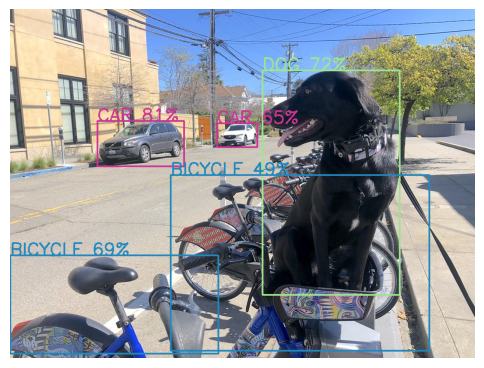

In [27]:
# loading image
image = preprocess_image(path='../data/image/coco_bike.jpg')

# getting predictions
pred = model(image)

# visualizing result
image_bbox = visualize(path='../data/image/coco_bike.jpg',pred=pred,n_bbox=5)
plt.figure(figsize=(6,6))
plt.imshow(image_bbox)
plt.axis(False)
plt.show()

In [ ]:
# saving model for further processes
MODEL_DIR_PATH = pathlib.Path("SavedModel")
MODEL_DIR_PATH.mkdir(exist_ok=True)

tf.saved_model.save(model,str(MODEL_DIR_PATH))

### Creating OpenVINO IR (Intermediate Representation) and compiling
It is useful to convert your model to IR format to take advantage of OpenVINO optimization tools and features.
* Convert TensorFlow model in SavedModel format to OpenVINO IR with the help of the openvino-dev (`mo`) python API.
* The above step will create an XML (network topology) and a bin (network weights) file that will be compiled with the OpenVino runtime module.

In [29]:
IR_PATH = pathlib.Path('IR')
IR_PATH.mkdir(exist_ok=True)

In [ ]:
from openvino.tools import mo
from openvino.runtime import serialize

model_ir = mo.convert_model(saved_model_dir=str(MODEL_DIR_PATH))
serialize(model_ir,'IR/efficientdet.xml')

In [31]:
from openvino.runtime import Core
core = Core()
# read converted model
model_ir = core.read_model(model='IR/efficientdet.xml',weights='IR/efficientdet.bin')
# load model on CPU device
compiled_model = core.compile_model(model_ir, 'CPU')
# saving keys of required information
output_keys = [compiled_model.output(4),  # CLASS KEY
               compiled_model.output(3),  # BBOX KEY
               compiled_model.output(6)]  # CONFIDENCE SCORE KEY

#### Verifying OpenVINO model inference
To test model inference, create an inference pipeline with the help of the above-defined utility functions\
The pipeline consists of :-
* Preprocessing : You need to perform preprocessing over the image, as the model expects the image to be in RGB, with shape [1,height, width,3] and values in UINT8 format. [ `preprocess_image()` function ]
* Inference of OpenVINO model.
* Post-processing : Since the model returns a ton of information like `detection_scores` ,`raw_detection_scores` ,`raw_detection_classes` ,`num_detection` , etc. Therefore , you need to post-process results to gather only required information like score (confidence) , classes, and bounding boxes. [ `visualize()` function ]

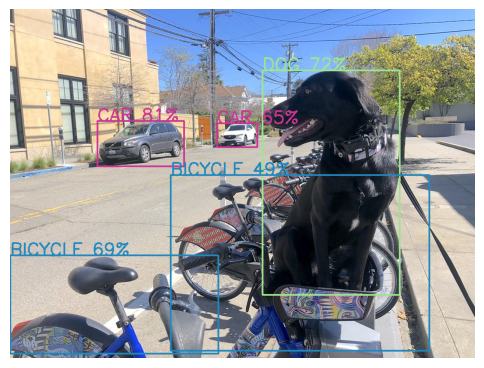

In [32]:
# loading image
IMG_PATH = pathlib.Path('../data/image/coco_bike.jpg')
img = preprocess_image(path=str(IMG_PATH))

# producing result
result = compiled_model([img])
result_dict = {'detection_scores':result[output_keys[2]],
               'detection_classes':result[output_keys[0]],
               'detection_boxes':result[output_keys[1]]}

# visualizing result
image_bbox = visualize(path='../data/image/coco_bike.jpg',pred=result_dict,n_bbox=5)
plt.figure(figsize=(6,6))
plt.imshow(image_bbox)
plt.axis(False)
plt.show()

### Verify the Accuracy of the compiled model
* Since EfficientDet models are trained with [COCO-2017](https://cocodataset.org/#download) dataset , you will use it to verify accuracy.
* To evaluate performance, you will use mAP metric ie. mean Average Precision
* To calculate mAP, you will use the COCO official API called [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools)

In [33]:
# Downloading Dataset and labels of COCO-VAL2017

from zipfile import ZipFile

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = pathlib.Path.cwd()

if not (OUT_DIR / "coco/labels").exists():
    download_file(url=DATA_URL)
    download_file(url=LABELS_URL)
    with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

In [34]:
from openvino.runtime import Model


def write_result(model:Model,image_dir:pathlib.Path,res_file:str,n_images:int = 100):
    """
    Create a JSON file with predictions in COCO format to evalute mAP

    Parameters:
        model(Model) : openvino 
        images_dir(Path) : Path of images directory
        res_file(str) : result file name 
        n_images(int) : number of images for which predictions must be wrote (first n)
    
    Returns:
        NONE
    """
    
    results = []
    images = sorted(pathlib.os.listdir(image_dir))[:n_images]  # first n_images

    # loop for finding result for each of n_images
    for _,i in enumerate(images, start=1):

        complete_path = pathlib.Path(image_dir) / i
        img_tensor = preprocess_image(path=str(complete_path))

        output_keys = [model.output(4),  # CLASS KEY
                       model.output(3),  # BBOX KEY
                       model.output(6)]  # CONFIDENCE SCORE KEY

        result = model([img_tensor])

        cat_ids ,scores, bboxs = result[output_keys[0]][0] , result[output_keys[2]][0] , result[output_keys[1]][0]

        for k in range(len(cat_ids)):

            __,h,w,c = img_tensor.shape
            score , cat_id , bbox = scores[k] , cat_ids[k] , bboxs[k]
            y_min ,x_min ,y_max ,x_max = bbox[0] * h ,bbox[1] * w ,bbox[2] * h ,bbox[3] * w

            # storing result in COCO format
            r = {'score':np.float64(score),
                 'image_id':int(i[:len(i) - 4]),
                 'category_id':int(cat_id),
                 'bbox':list(np.array([x_min, y_min , x_max - x_min, y_max - y_min]).astype(np.float64))}

            results.append(r)

        if (_ % 10 == 0):
            print(f'{_}/{n_images} predictions stored ')
    
    with open(res_file,'w') as result_file:
        json.dump(results,result_file)

##### Evaluating Performance of OpenVINO model
* First, you will write the results produced by the model in COCO format in a JSON file with `write_result()` function.
* Then you will use COCO official API for model evaluation on the COCO dataset.

In [ ]:
# writing predictions
images_folder = pathlib.Path('coco/images/val2017')
result_file = 'result.json'
write_result(model=compiled_model,image_dir=images_folder,res_file=result_file,n_images=100)

In [36]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annType = 'bbox'

cocoGT = COCO('coco/annotations/instances_val2017.json')
cocoDT = cocoGT.loadRes('result.json')

imgIds = sorted(cocoGT.getImgIds())
imgIds = imgIds[0:100]  # using first 100 ids as model is being evaluated on those images only

cocoEval = COCOeval(cocoGT,cocoDT,annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.33s).
Accumulating evaluation results...
DONE (t=0.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### Optimize model using NNCF Post-training Quantization API [**WILL BE INCLUDED LATER**]
<a href='https://github.com/openvinotoolkit/nncf'>NNCF</a> provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop. We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize EfficientDet.

The optimization process contains the following steps:
1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using openvino.runtime.serialize function

```python
import nncf
def transform_fn(data_item):
    """
    Create image tensor for quantization process

    Parameters:
        data_item : tensorflow dataset object
    
    Returns:
        img(tf.tensor) : tensor of image in shape (1,512,512,3)
    """
    data_item = pathlib.Path(data_item.numpy().decode('UTF8'))
    img = preprocess_image(data_item) 
    return img
```
```python
# creating dataset for accuracy testing
dataloader = tf.data.Dataset.list_files('coco/images/val2017/*.jpg',shuffle=False)  # itterable Data Object
quantization_dataset = nncf.Dataset(dataloader, transform_fn)

# loading original openvino-model for quantization
OpenVino_model = core.read_model(model='IR/efficientdet.xml',weights='IR/efficientdet.bin')
```
```python
quantized_model = nncf.quantize(OpenVino_model, quantization_dataset)  
# specify `preset` in nncf.quantize() for better result , Default optimizer will be used otherwise

serialize(quantized_model,'int8_IR/efficientDet-D0_int8.xml')
```

